# PM10 Project Notebook 2 (LSTM)

#### Project description:

    PM10 are small airborne particles with a diameter of 10 micrometer or less. As they are so small, they are especially adverse for health since they penetrate deep into our lungs.

    We want to predict PM10 pollution measured at selected air monitoring stations 24 hours in advance. 


#### Contributors
    Anke Schürmann
    Friedrich Kerchnawe
    Philipp Jordt

### Import necessary packages

In [51]:
import os
import pandas as pd
import io
import time
import math 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
from collect_data import make_PM10_df_v0

### Upload Data to Notebook
<br> 
For jupyter notebook upload from local machine

In [52]:
Dataset_long = make_PM10_df_v0("Luftqualitaet_DESH027_Kiel-Bahnhofstr.csv", "Wetter_Holtenau")

#### Data Corrections

In [53]:
Dataset_long.F = Dataset_long.F.replace(-999, np.nan)
Dataset_long.RS_IND = Dataset_long.RS_IND.replace(-999, np.nan)
Dataset_long.RF_TU = Dataset_long.RF_TU.replace(-999, np.nan)
Dataset_long.TT_TU = Dataset_long.TT_TU.replace(-999, np.nan)
Dataset_long.PP_TER = Dataset_long.PP_TER.replace(-999, np.nan)
Dataset_long.V_N = Dataset_long.V_N.replace(-1, np.nan)

#### Table of the included/accessible data


| Datasetname | Description |
| --- | --- |
| Datum | pandas datetime |
| PM10 | PM10 measured at Bahnhof (µg/m³)|
| Ozon | Ozon measured at Bahnhof (µg/m³)|
| NO2 | NO2 measured at Bahnhof (µg/m³)|
| ~PM10_BrKa~ | ~PM10 measured at Bremerskamp (µg/m³)~|
| ~Ozon_BrKa~ | ~Ozon measured at Bremerskamp (µg/m³)~|
| ~NO2_BrKa~ | ~NO2 measured at Bremerskamp (µg/m³)~|
| Schulfrei | school free in SH (1/0) |
| F  | wind velocity (in m/sec)  |
| D  | wind direction (in deg)  |
| FX_911  | max wind velocity (in m/sec)  |
| PP_TER  | air pressure (in hpa)  |
| TT_TU  | airtemperature (in °C)  |
| RF_TU  | relative humidity (in %)  |
| V_N  | degree of coverage of all clouds (in eights)  |
| R1  | rain amount per hour (in mm)  |
| RS_IND  | hourly indictaion of rain (1/0)  |
| WRTR  | type of rainfall (numeric code)  |
| ABSF_STD  | absolute humidity  |
| VP_STD  | berechnete Stundenwerte des Dampfdruckes (in hpa)  |
| TF_STD  | berechnete Stundenwerte der Feuchttemperatur (in °C)  |
| RF_STD  | Stundenwerte der Relativen Feuchte (in %)  |
| TD_STD  | Taupunkttemperatur in 2m Hoehe (in °C)  |



access data with index Datasetname e.g. `Dataset_long.F`

## Setup Tensorflow dataset


In [97]:
frames = [Dataset_long.Datum.dt.year,
          Dataset_long.Datum.dt.dayofyear,
          Dataset_long.Datum.dt.hour,
          pd.DataFrame(Dataset_long.Datum.dt.dayofweek==0, dtype=int),
          pd.DataFrame(Dataset_long.Datum.dt.dayofweek==1, dtype=int),
          pd.DataFrame(Dataset_long.Datum.dt.dayofweek==2, dtype=int),
          pd.DataFrame(Dataset_long.Datum.dt.dayofweek==3, dtype=int),
          pd.DataFrame(Dataset_long.Datum.dt.dayofweek==4, dtype=int),
          pd.DataFrame(Dataset_long.Datum.dt.dayofweek==5, dtype=int),
          pd.DataFrame(Dataset_long.Datum.dt.dayofweek==6, dtype=int),
          Dataset_long.F,
          Dataset_long.D,
          Dataset_long.FX_911,
          Dataset_long.PP_TER,
          Dataset_long.TT_TU,
          Dataset_long.RF_TU,
          Dataset_long.V_N,
          Dataset_long.RS_IND,
          Dataset_long.PM10]
Datasets = pd.concat(frames, axis= 1)

## LSTM model and training

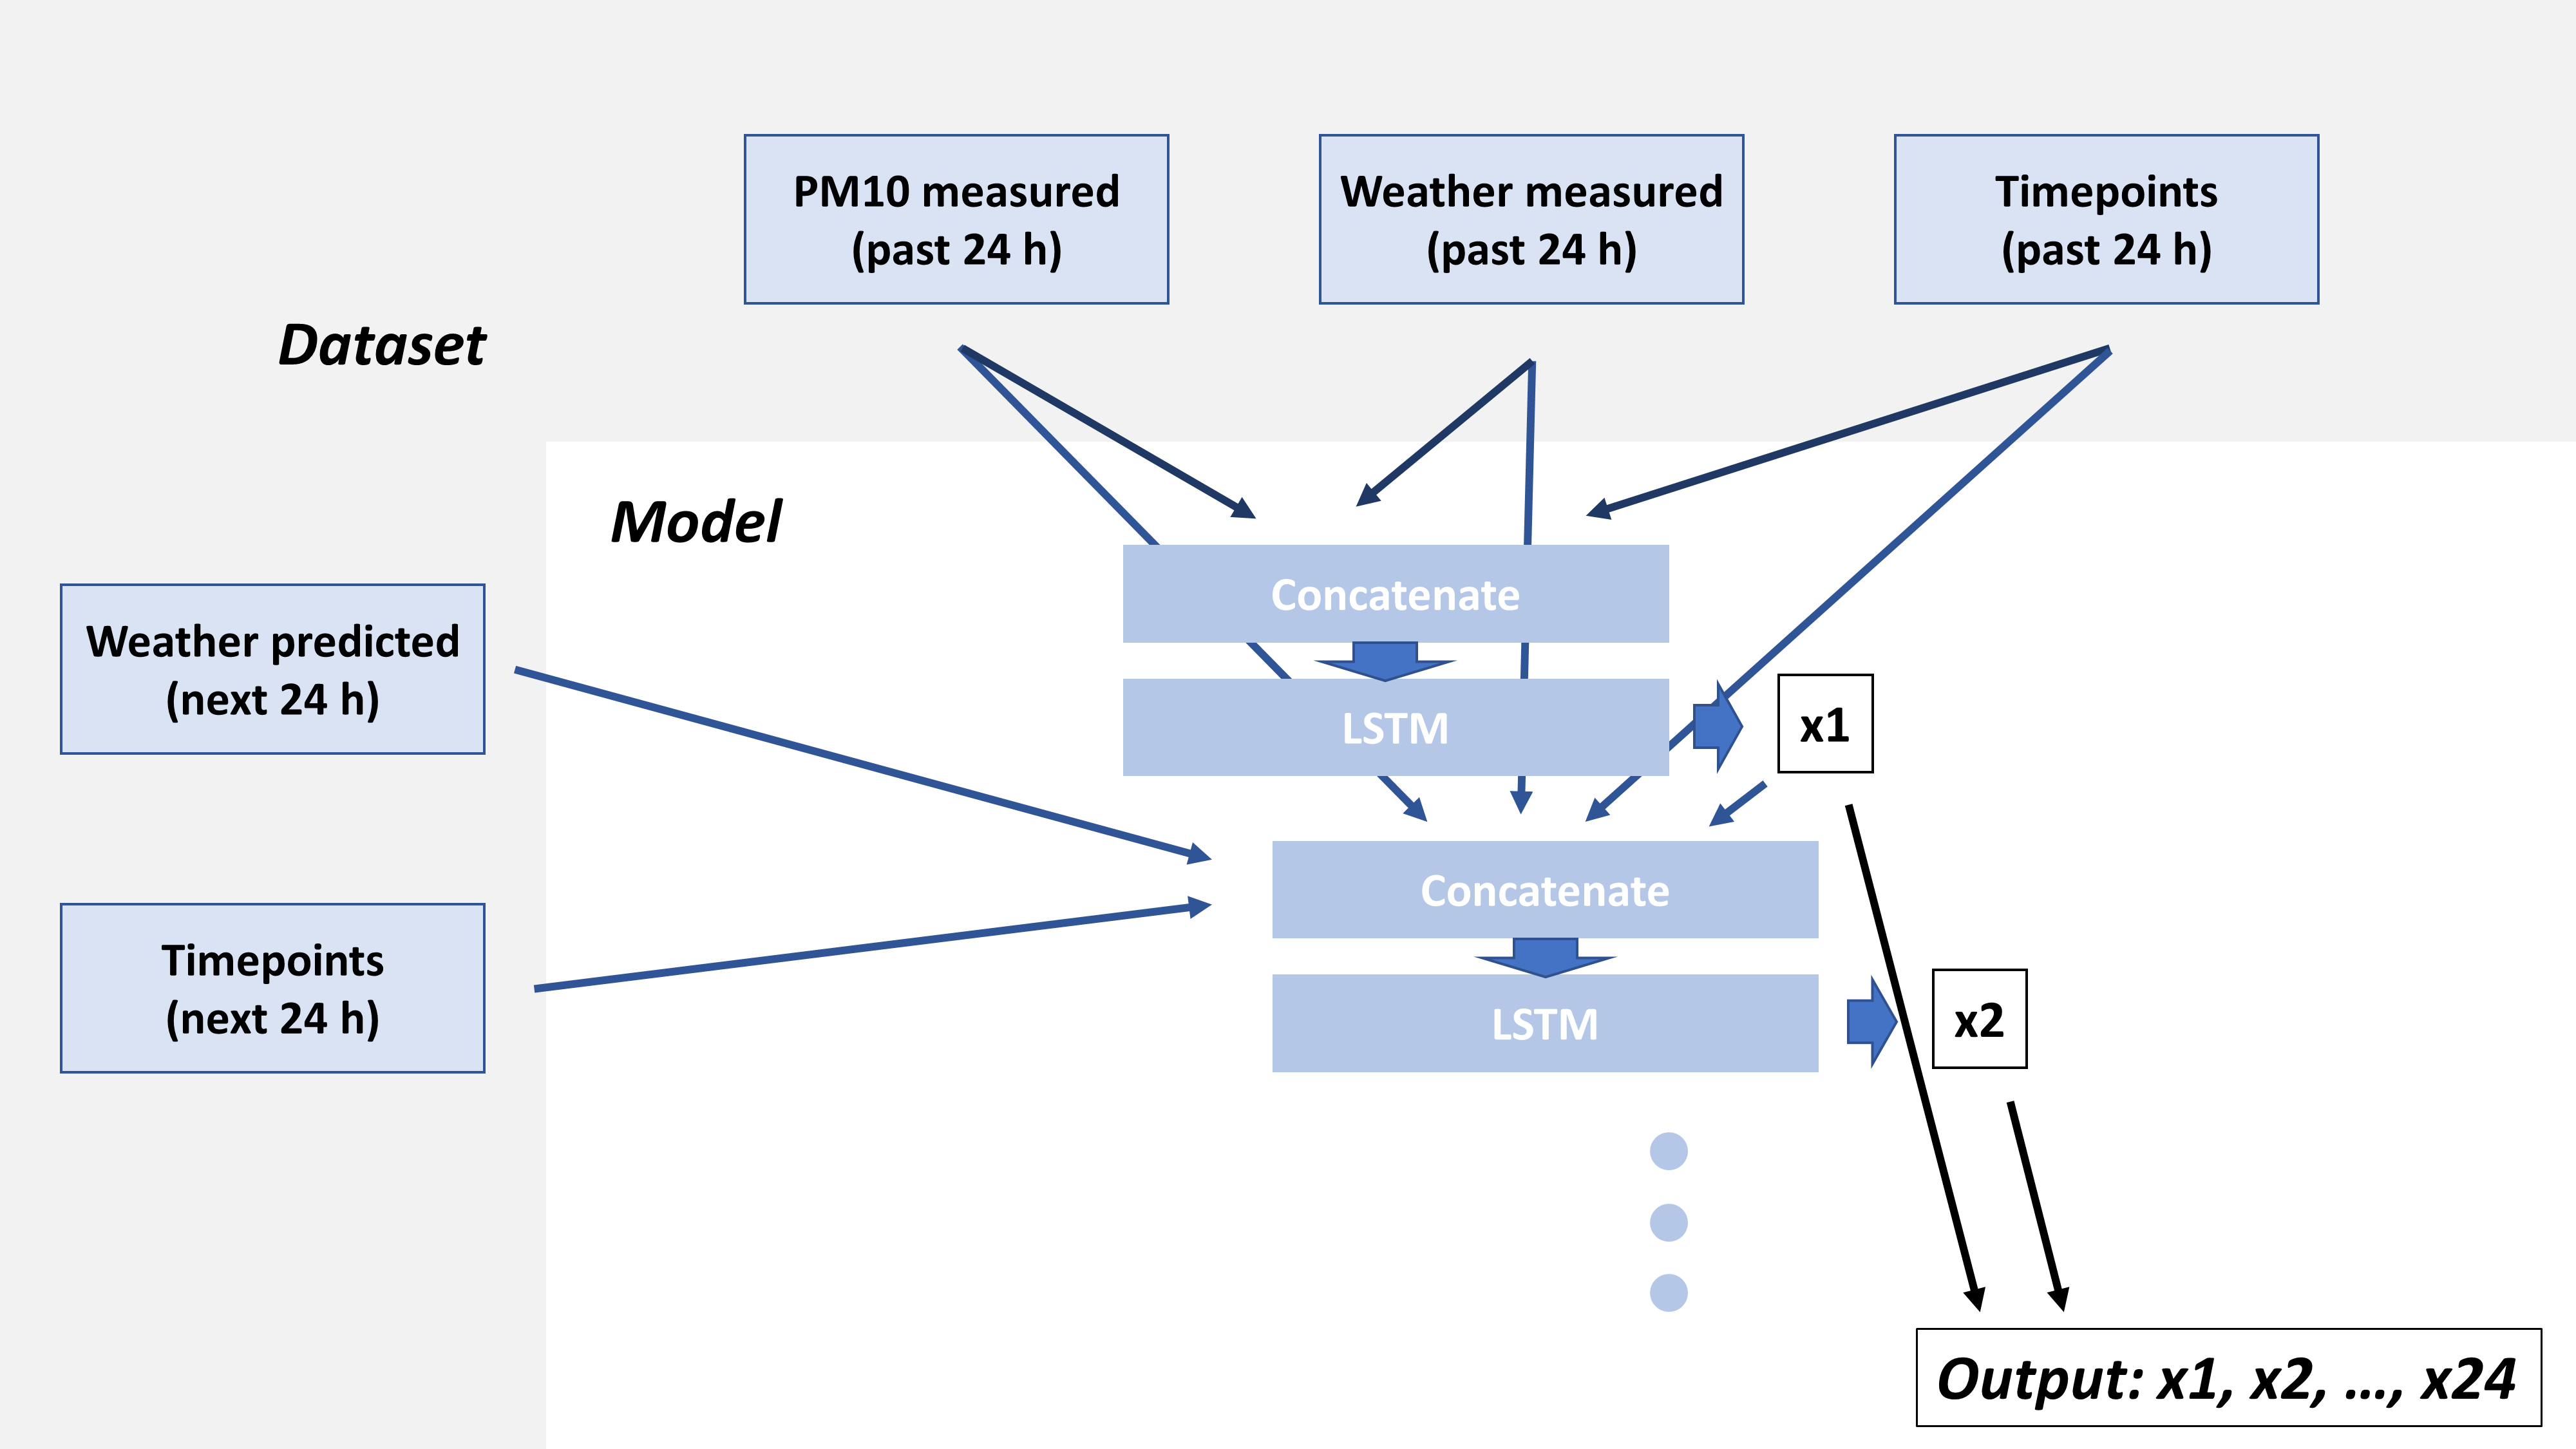

In [98]:
target_str = 'PM10'
Dataset = Datasets.dropna()
val= Dataset.values

batchsize= 24 # hours to take into account in the RNN
datasize= np.floor(val.shape[0]/batchsize)
traincut= np.round(datasize*0.75)
hourind= 23

vals= val[:int(datasize*batchsize)].reshape((-1,batchsize,val.shape[1]))

## Training
measured_PM10 = vals[:int(traincut)-1, :, -1]
measured_weather = vals[:int(traincut)-1, :, 10:-1]
measured_timepoint = vals[:int(traincut)-1, :, :10]
pred_weather = vals[1:int(traincut), :, 10:-1]
pred_timepoint = vals[1:int(traincut), :, :10]
target_PM10 = vals[1:int(traincut), :24, -1]

## Testing
measured_PM10_test = vals[int(traincut):-2, :, -1]
measured_weather_test = vals[int(traincut):-2, :, 10:-1]
measured_timepoint_test = vals[int(traincut):-2, :, :10]
pred_weather_test = vals[int(traincut)+1:-1, :, 10:-1]
pred_timepoint_test = vals[int(traincut)+1:-1, :, :10]
target_PM10_test = vals[int(traincut)+1:-1, :24, -1]

# enlarge the dataset, choose from (1, range(1, batchsize), [4, 8, 12, 16, 20], ...)
if True:
    for i in [4, 8, 12, 16, 20]: 
        vals= val[i:int((datasize- 1)* batchsize)+i].reshape((-1,batchsize,val.shape[1]))

        ## Training
        measured_PM10 = np.append(measured_PM10, vals[:int(traincut)-1, :, -1], axis= 0)
        measured_weather = np.append(measured_weather, vals[:int(traincut)-1, :, 10:-1], axis= 0)
        measured_timepoint = np.append(measured_timepoint, vals[:int(traincut)-1, :, :10], axis= 0)
        pred_weather = np.append(pred_weather, vals[1:int(traincut), :, 10:-1], axis= 0)
        pred_timepoint = np.append(pred_timepoint, vals[1:int(traincut), :, :10], axis= 0)
        target_PM10 = np.append(target_PM10, vals[1:int(traincut), :24, -1], axis= 0)

# shuffle the dataset        
if True:
    rng = np.random.default_rng()  
    indexes= np.arange(measured_PM10.shape[0])
    rng.shuffle(indexes) 
    
    measured_PM10 = measured_PM10[indexes] 
    measured_weather = measured_weather[indexes] 
    measured_timepoint = measured_timepoint[indexes] 
    pred_weather = pred_weather[indexes] 
    pred_timepoint = pred_timepoint[indexes] 
    target_PM10 = target_PM10[indexes] 

# setup and adapt normalizer
if True:
    norm_Weather = tf.keras.layers.Normalization(axis= 2)
    norm_Weather.adapt(measured_weather)
    norm_Timepoint = tf.keras.layers.Normalization(axis= 2)
    norm_Timepoint.adapt(measured_timepoint)

In [99]:
# check shape of train and test set
print(measured_weather.shape)
print(measured_weather_test.shape)

(5874, 24, 8)
(325, 24, 8)


In [111]:
def get_compiled_model_RNN(No_layer= 1, No_units= [16, 16], Act= 'tanh', kernelRegularizer= None, recurrentRegularizer= None, activityRegularizer= None, rec_dropout= 0.0, dropout= 0.0, dense_End= True):  
    #No_layer= 1 # No of LSTM layers per prection timepoint
    #Act= 'tanh' # activation function of the LSTM layers
    #dense_End= True # define if a dense layer should be used right before the output 
    ######
    
    mPM_input = tf.keras.Input(shape=(24,1,), name="measuredPM10")
    mWea_input1 = tf.keras.Input(shape=(24,8,), name="measuredWeather")
    mTi_input1 = tf.keras.Input(shape=(24,10,), name="measuredTimepoint")
    pWea_input1 = tf.keras.Input(shape=(24,8,), name="predWeather")
    pTi_input1 = tf.keras.Input(shape=(24,10,), name="predTimepoint")
    
    if True:
        mWea_input = norm_Weather(mWea_input1)
        mTi_input = norm_Timepoint(mTi_input1)
        pWea_input = norm_Weather(pWea_input1)
        pTi_input = norm_Timepoint(pTi_input1)
    
    PM10= tf.keras.layers.Lambda(lambda x: x / 100.0 - 0.2)(mPM_input)
    #PM10= mPM_input
    Weather= mWea_input
    Time= mTi_input
    
    for index in range(1, 25):
        x = tf.concat([PM10, Weather, Time], axis=2)
        x = tf.keras.layers.Conv1D(filters= 16, kernel_size= 5, activation= 'tanh', kernel_regularizer= kernelRegularizer, input_shape= x.shape[1:])(x)
        x = tf.keras.layers.AveragePooling1D(pool_size= 2)(x)
        x = tf.keras.layers.Conv1D(filters= 32, kernel_size= 5, activation= 'tanh', kernel_regularizer= kernelRegularizer)(x)
        if No_layer == 1: 
            x = tf.keras.layers.LSTM(units= No_units[0], activation= Act, kernel_regularizer= kernelRegularizer, recurrent_regularizer= recurrentRegularizer, activity_regularizer= activityRegularizer, dropout= dropout, recurrent_dropout= rec_dropout, return_sequences=False)(x)
        elif No_layer == 2:
            x = tf.keras.layers.LSTM(units= No_units[0], activation= Act, kernel_regularizer= kernelRegularizer, recurrent_regularizer= recurrentRegularizer, activity_regularizer= activityRegularizer, dropout= dropout, recurrent_dropout= rec_dropout, return_sequences=True)(x)
            x = tf.keras.layers.LSTM(units= No_units[1], activation= Act, kernel_regularizer= kernelRegularizer, recurrent_regularizer= recurrentRegularizer, activity_regularizer= activityRegularizer, dropout= dropout, recurrent_dropout= rec_dropout, return_sequences=False)(x)  
        x = tf.keras.layers.Dense(32, activation= 'relu', kernel_regularizer= kernelRegularizer)(x)
        x = tf.keras.layers.Dense(16, activation= 'relu', kernel_regularizer= kernelRegularizer)(x)
        x = tf.keras.layers.Dense(1, activation= None, kernel_regularizer= kernelRegularizer)(x)

        PM10add= tf.reshape(x, [-1 , 1, 1])
        PM10= tf.concat([PM10, PM10add], axis=1)
        Weather= tf.concat([mWea_input, pWea_input[:, :index, :]], axis=1)
        Time= tf.concat([mTi_input, pTi_input[:, :index, :]], axis=1)
        if index == 1:
            Pred= tf.concat([x], axis=1)
        else:
            Pred= tf.concat([Pred, x], axis=1)   
    
    if dense_End == 0:
        pred = tf.keras.layers.Lambda(lambda x: (x + 0.2) * 100.0, name="targetPM10")(Pred)
    elif dense_End == 1:
        #Pred = tf.keras.layers.Dense(128, kernel_regularizer= kernelRegularizer, activation='tanh')(Pred)
        Pred = tf.keras.layers.Dense(32, kernel_regularizer= kernelRegularizer, activation='tanh')(Pred)
        Pred = tf.keras.layers.Dense(24, kernel_regularizer= kernelRegularizer)(Pred)
        pred = tf.keras.layers.Lambda(lambda x: (x + 0.2) * 100.0, name="targetPM10")(Pred)

    model = tf.keras.Model(
        inputs=[mPM_input, mWea_input1, mTi_input1, pWea_input1, pTi_input1], 
        outputs=[pred],
    )
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
        loss=tf.keras.losses.MeanAbsolutePercentageError(),
        metrics=[tf.keras.metrics.MeanAbsolutePercentageError()]
    )
    return model

In [112]:
# learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    elif lr < 1e-6:
        return lr
    else:
        return lr * 0.95

model_RNN = get_compiled_model_RNN(
    No_layer= 1, 
    No_units= [48, 32], # number of units in LSTM layer 1 and layer 2
    Act= 'tanh', 
    kernelRegularizer= 'l1', # None, 'l1_l2', 'l2', tf.keras.regularizers.L1(l1= 0.01)
    recurrentRegularizer= 'l1',
    activityRegularizer= 'l1',
    dropout= 0.0, 
    rec_dropout= 0.0, 
    dense_End= False
)

model_RNN.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsolutePercentageError()]
)

# callbacks for .fit
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=5, cooldown= 2, min_lr=1e-6)
schedule_lr = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose= 1)

history_RNN= model_RNN.fit(
    {"measuredPM10": measured_PM10, "measuredWeather": measured_weather, "measuredTimepoint": measured_timepoint, "predWeather": pred_weather, "predTimepoint": pred_timepoint}, 
    {"targetPM10": target_PM10}, 
    verbose=1,
    epochs=50,
    batch_size=32,
    callbacks=[
        reduce_lr,
        schedule_lr
    ],
    validation_data=(
        {"measuredPM10": measured_PM10_test, "measuredWeather": measured_weather_test, "measuredTimepoint": measured_timepoint_test, "predWeather": pred_weather_test, "predTimepoint": pred_timepoint_test}, 
        {"targetPM10": target_PM10_test}
    )
)


Epoch 00001: LearningRateScheduler setting learning rate to 0.003000000026077032.
Epoch 1/50
184/184 [==============================] - 402s 2s/step - loss: 327.7356 - mean_absolute_percentage_error: 32.5225 - val_loss: 225.7638 - val_mean_absolute_percentage_error: 33.2601 - lr: 0.0030

Epoch 00002: LearningRateScheduler setting learning rate to 0.003000000026077032.
Epoch 2/50
184/184 [==============================] - 289s 2s/step - loss: 185.1054 - mean_absolute_percentage_error: 25.3236 - val_loss: 148.7275 - val_mean_absolute_percentage_error: 25.6667 - lr: 0.0030

Epoch 00003: LearningRateScheduler setting learning rate to 0.003000000026077032.
Epoch 3/50
184/184 [==============================] - 304s 2s/step - loss: 129.6411 - mean_absolute_percentage_error: 23.0133 - val_loss: 117.6475 - val_mean_absolute_percentage_error: 30.0623 - lr: 0.0030

Epoch 00004: LearningRateScheduler setting learning rate to 0.003000000026077032.
Epoch 4/50
184/184 [==============================

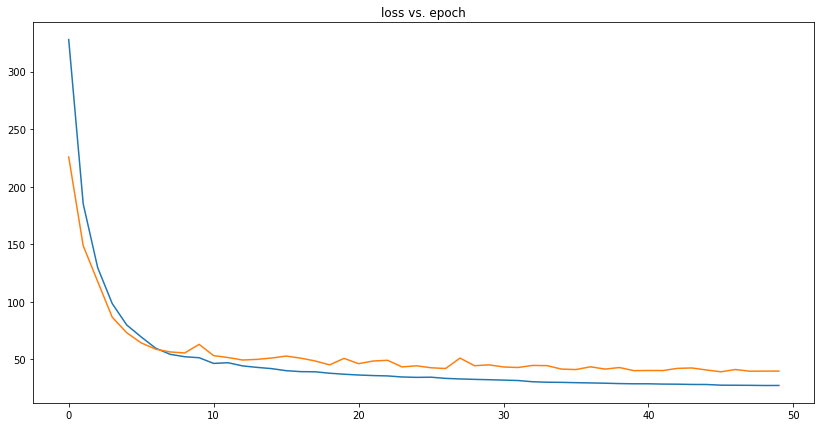

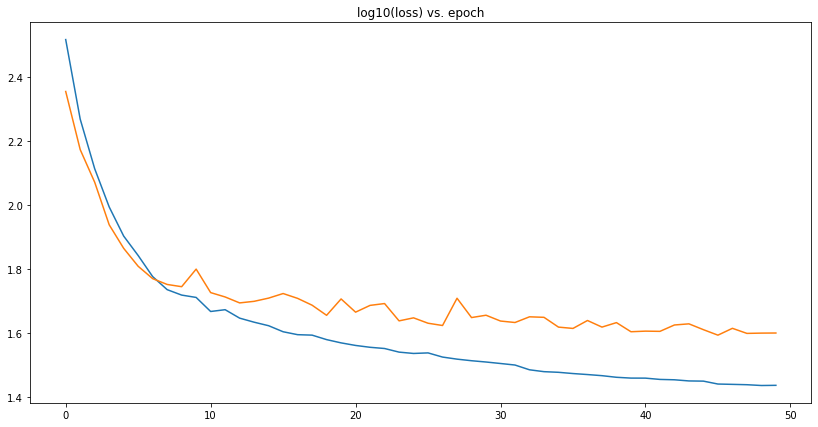

In [115]:
plt.figure(figsize=(14,7))
plt.plot(history_RNN.epoch[:], history_RNN.history['loss'][:])
plt.plot(history_RNN.epoch[:], history_RNN.history['val_loss'][:])
plt.title('loss vs. epoch')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(history_RNN.epoch[:], np.log10(history_RNN.history['loss'][:]))
plt.plot(history_RNN.epoch[:], np.log10(history_RNN.history['val_loss'][:]))
plt.title('log10(loss) vs. epoch')
plt.show()

#### Model summary and graph

In [116]:
model_RNN.summary()

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 measuredPM10 (InputLayer)      [(None, 24, 1)]      0           []                               
                                                                                                  
 measuredWeather (InputLayer)   [(None, 24, 8)]      0           []                               
                                                                                                  
 measuredTimepoint (InputLayer)  [(None, 24, 10)]    0           []                               
                                                                                                  
 lambda_17 (Lambda)             (None, 24, 1)        0           ['measuredPM10[0][0]']           
                                                                                           

In [1]:
tf.keras.utils.plot_model(model_RNN, "Model_LSTM_adv_1.png", show_shapes=False)

#### Evaluate and visiulize results

In [118]:
model_RNN.evaluate(
    {"measuredPM10": measured_PM10, "measuredWeather": measured_weather, "measuredTimepoint": measured_timepoint, "predWeather": pred_weather, "predTimepoint": pred_timepoint}, 
    {"targetPM10": target_PM10}
)
model_RNN.evaluate(
    {"measuredPM10": measured_PM10_test, "measuredWeather": measured_weather_test, "measuredTimepoint": measured_timepoint_test, "predWeather": pred_weather_test, "predTimepoint": pred_timepoint_test}, 
    {"targetPM10": target_PM10_test}
)

11/11 [==============================] - 6s 509ms/step - loss: 39.8507 - mean_absolute_percentage_error: 20.5090


[39.850650787353516, 20.50901222229004]


---Prediction for future timepoint in 24 hours---
predicted values: [21. 21. 18. 13. 23. 23. 17. 14. 13. 15.]
target values:    [17. 12. 10.  5.  7. 13. 17.  8. 10. 12.]
MAPE: 22.966562271118164

---Check MAPE for prediction of high PM10 values (>35)---
MAPE: 31.555070877075195
------



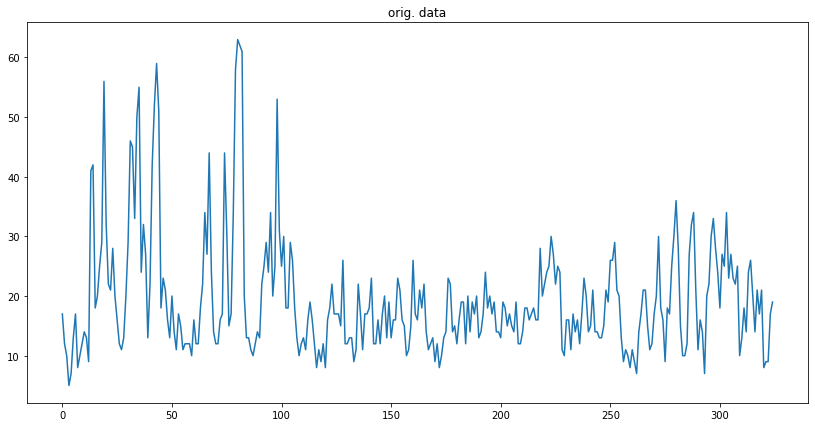

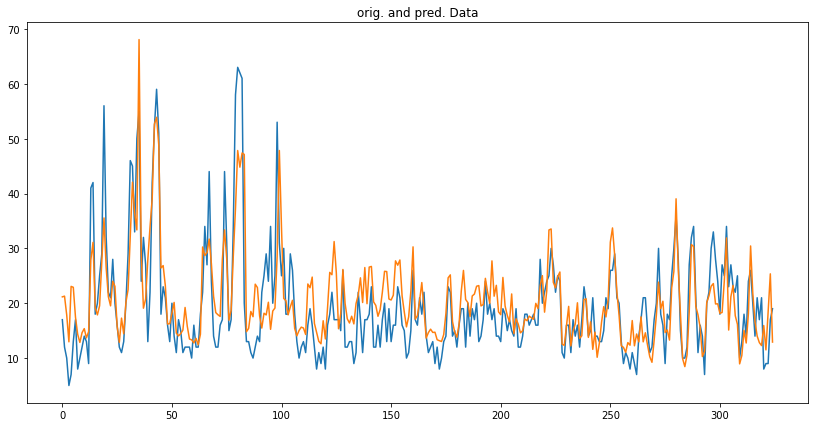

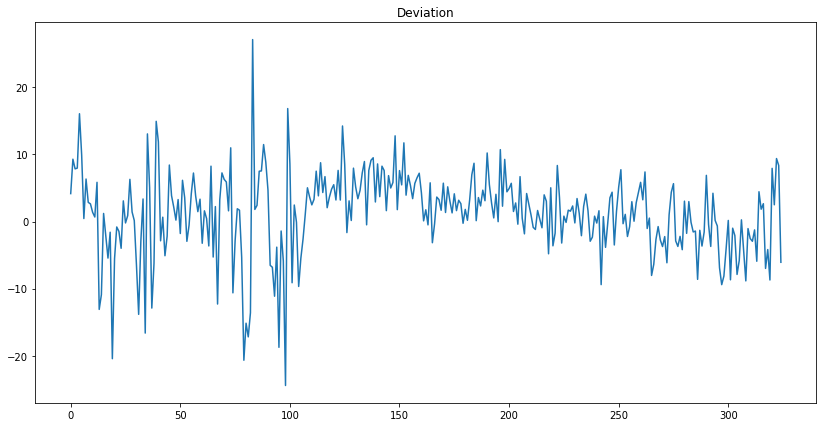

Mean of deviation: 4.754148304279034
Standard deviation: 4.165105022139876


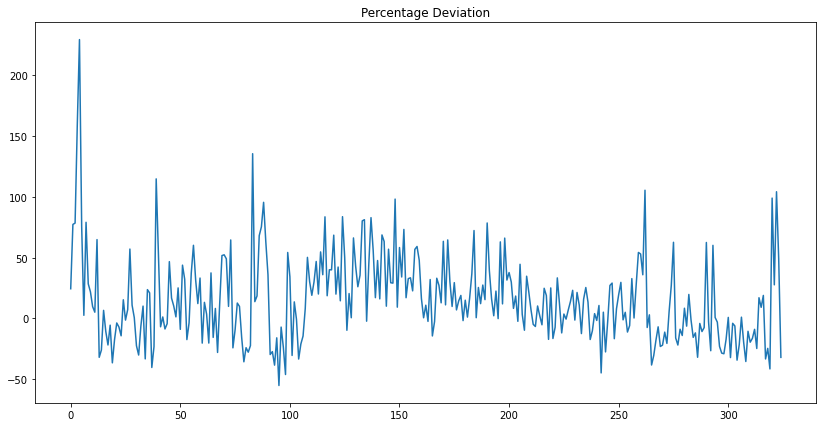

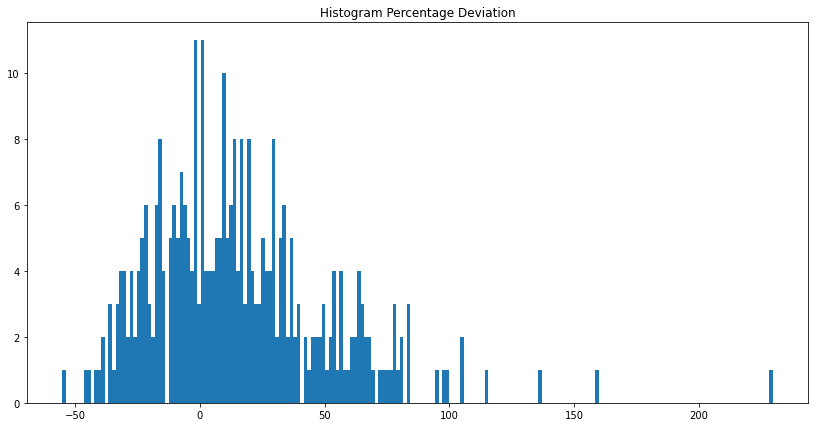

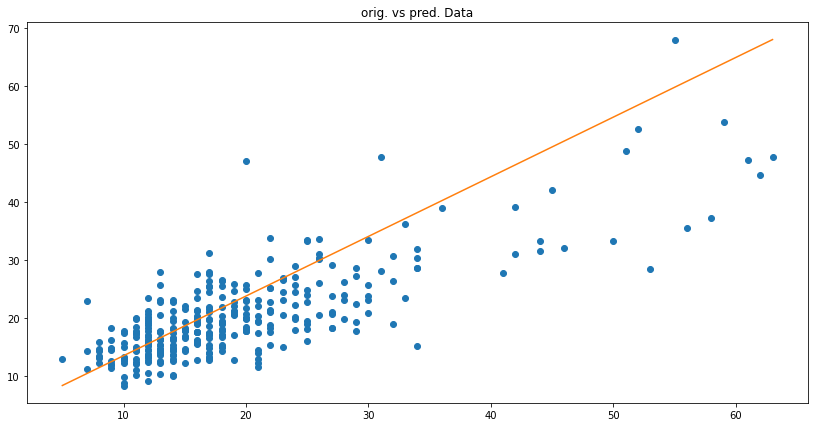

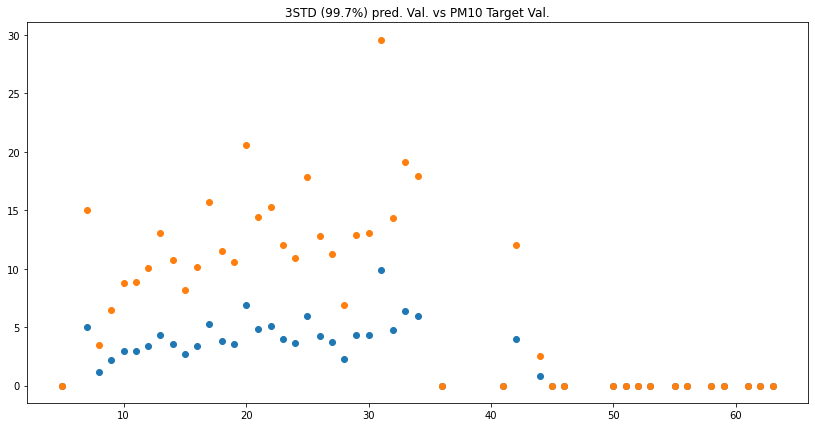

In [119]:
hourind= 23
print(f'\n---Prediction for future timepoint in {hourind+1} hours---')

pred_val= model_RNN.predict({"measuredPM10": measured_PM10_test, "measuredWeather": measured_weather_test, "measuredTimepoint": measured_timepoint_test, "predWeather": pred_weather_test, "predTimepoint": pred_timepoint_test}).squeeze()[:, hourind]
target_val= target_PM10_test[:, hourind]
if False:
    pred_val= pred_val*100.0
    target_val= target_val*100.0
print(f'predicted values: {np.round(pred_val[:10]).T}')
print(f'target values:    {target_val[:10].T}')

m= tf.metrics.MeanAbsolutePercentageError()
m.update_state(pred_val.T, target_val.T)
accu= m.result().numpy()
print(f'MAPE: {accu}')

print('\n---Check MAPE for prediction of high PM10 values (>35)---')
m= tf.metrics.MeanAbsolutePercentageError()
m.update_state(pred_val[target_val>35].T, target_val[target_val>35].T)
accu= m.result().numpy()
print(f'MAPE: {accu}')
print('------\n')

plt.figure(figsize=(14,7))
plt.plot(target_val)
plt.title('orig. data')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(target_val)
plt.plot(pred_val)
plt.title('orig. and pred. Data')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(np.subtract(pred_val,target_val))
plt.title('Deviation')
plt.show()
print(f'Mean of deviation: {np.mean(np.abs(np.subtract(pred_val,target_val)))}')
print(f'Standard deviation: {np.std(np.abs(np.subtract(pred_val,target_val)))}')

plt.figure(figsize=(14,7))
plt.plot(np.divide(np.subtract(pred_val,target_val),target_val)*100)
plt.title('Percentage Deviation')
plt.show()

plt.figure(figsize=(14,7))
plt.hist(np.divide(np.subtract(pred_val,target_val),target_val)*100, bins= 200)#, range= (-15, 15))
plt.title('Histogram Percentage Deviation')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(target_val, pred_val,'o')
plt.plot([target_val.min(), target_val.max()], [pred_val.min(), pred_val.max()])
plt.title('orig. vs pred. Data')
plt.show()

pset= pd.DataFrame(data={'y_p':pred_val.squeeze(), 'y_t':target_val.squeeze()})
vals_std= pset.groupby(['y_t']).std(ddof= 0)

plt.figure(figsize=(14,7))
plt.scatter(vals_std.index, vals_std.values)
plt.scatter(vals_std.index, np.multiply(vals_std.values,3))
plt.title('3STD (99.7%) pred. Val. vs PM10 Target Val.')
plt.show()